In [8]:
from dolphindb import session
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import sys
import os
import traceback
from scipy.interpolate import CubicSpline
import yfinance as yf
# Import libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import warnings

# Set the style for plotting
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [9]:
def get_data(ticker=None, period='2y', interval='1h'):
    """
    Get stock data from Yahoo Finance
    
    Parameters:
    ticker (str): Ticker symbol (e.g., 'PETR4.SA')
    period (str): Period to download ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    
    Returns:
    DataFrame: DataFrame with OHLCV data
    """
    if ticker is None:
        return None
    
    try:
        data = yf.download(ticker, period=period, interval=interval, progress=False)
        
        if data.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Check if we got a MultiIndex DataFrame (happens with group_by='ticker')
        if isinstance(data.columns, pd.MultiIndex):
            print(f"Detected MultiIndex columns, flattening index structure...")
            # If it's just one ticker, we can flatten the columns
            if ticker and ',' not in ticker:
                # Create a flat DataFrame with single-level column names
                flat_data = pd.DataFrame()
                for col_name in ['Open', 'High', 'Low', 'Close', 'Volume']:
                    if (col_name, ticker) in data.columns:
                        flat_data[col_name] = data[(col_name, ticker)]
                    elif col_name in data.columns.get_level_values(0):
                        # Find the right column if ticker doesn't match exactly
                        for second_level in data.columns.get_level_values(1).unique():
                            if (col_name, second_level) in data.columns:
                                flat_data[col_name] = data[(col_name, second_level)]
                                break
                
                # Ensure we have the index (dates/times)
                flat_data.index = data.index
                data = flat_data
            else:
                # For multiple tickers, we'll need a different approach
                # Just flatten column names with a join for now
                data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]
        
        # Convert index to column for further processing
        transformed_data = data.copy()
        transformed_data.reset_index(inplace=True)
        
        # Ensure Datetime column exists and is named correctly
        if 'index' in transformed_data.columns:
            transformed_data.rename(columns={'index': 'Datetime'}, inplace=True)
        elif 'Date' in transformed_data.columns:
            transformed_data.rename(columns={'Date': 'Datetime'}, inplace=True)
            
        transformed_data['Symbol'] = ticker
        
        return transformed_data
    
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        traceback.print_exc()
        return None
    
def calculate_returns(data, ticker, period, iterations, forecast_days, hours_per_day=7):
    """
    Calculate returns and run Monte Carlo bootstrap simulation on hourly data
    
    Parameters:
    data (DataFrame): DataFrame with OHLCV data from yfinance
    ticker (str): Ticker symbol
    period (str): Period for historical data analysis
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average number of trading hours per day, default is 7
    
    Returns:
    dict: Results of the Monte Carlo simulation
    """
    # Copy the dataframe to avoid modifying the original
    asset_df = data.copy()
    
    # Check if we have the right columns and structure
    print(f"DataFrame columns: {asset_df.columns.tolist()}")
    print(f"DataFrame shape: {asset_df.shape}")
    
    # Handle MultiIndex columns if they exist
    if isinstance(asset_df.columns, pd.MultiIndex):
        print("Converting MultiIndex columns to flat structure...")
        # Find the Close column in the MultiIndex
        close_col = None
        for col in asset_df.columns:
            if isinstance(col, tuple) and col[0] == 'Close':
                close_col = col
                break
        
        if close_col:
            # Extract Close price and create a new flat DataFrame
            asset_df = pd.DataFrame({
                'Close': asset_df[close_col],
                'Datetime': asset_df.index if 'Datetime' not in asset_df.columns else asset_df['Datetime']
            })
        else:
            raise ValueError(f"Could not find Close price column in MultiIndex columns: {asset_df.columns.tolist()}")
    
    # Ensure 'Close' exists in the data with proper capitalization
    if 'Close' not in asset_df.columns:
        if 'close' in asset_df.columns:
            asset_df['Close'] = asset_df['close']
        else:
            # Try to find a column that might be the close price
            close_candidates = [col for col in asset_df.columns if 'close' in str(col).lower()]
            if close_candidates:
                asset_df['Close'] = asset_df[close_candidates[0]]
            else:
                raise ValueError(f"No Close price column found in data. Available columns: {asset_df.columns.tolist()}")
    
    # Calculate returns
    asset_df['simple_return'] = asset_df['Close'].pct_change()
    asset_df['log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Before dropping NaN values, verify column existence
    if 'simple_return' not in asset_df.columns or 'log_return' not in asset_df.columns:
        print("Warning: Return columns not created properly. Column list:", asset_df.columns.tolist())
        # Re-attempt column creation with explicit column names
        asset_df.loc[:, 'simple_return'] = asset_df['Close'].pct_change()
        asset_df.loc[:, 'log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Now it's safe to drop NaN values as we've created the columns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
    
    # Check if we have enough data after cleaning
    if len(asset_df) < 30:  # Arbitrary minimum, adjust as needed
        raise ValueError(f"Not enough data points after cleaning: {len(asset_df)} rows")
    
    # Get empirical distribution of returns
    cdf_values = calculate_cdf_values(asset_df)
    
    # Run Monte Carlo simulation
    # Calculate time_steps as hours_per_day * forecast_days
    time_steps = hours_per_day * forecast_days
    mc_results = mc_bootstrap(
        cdf_values['S0'], 
        cdf_values['interpolated_cdf_values'], 
        cdf_values['sorted_values'], 
        time_steps=time_steps, 
        iterations=iterations,
        hours_per_day=hours_per_day
    )
    
    # Prepare results
    results = {
        'ticker': ticker,
        'last_price': float(cdf_values['S0']),
        'historical_stats': {
            'mean_return': float(asset_df['simple_return'].mean()),
            'std_return': float(asset_df['simple_return'].std()),
            'median_return': float(asset_df['simple_return'].median()),
            'skew': float(asset_df['simple_return'].skew()),
            'kurtosis': float(asset_df['simple_return'].kurtosis())
        },
        'monte_carlo': mc_results
    }
    
    return results, asset_df

def calculate_cdf_values(asset_df):
    """
    Calculate the CDF values for the empirical distribution of log returns
    
    Parameters:
    asset_df (DataFrame): DataFrame with log_return column
    
    Returns:
    dict: CDF values and related statistics
    """
    # Ensure we have log_return column
    if 'log_return' not in asset_df.columns:
        raise ValueError("log_return column not found in data")
    
    # Get unique sorted values of log returns
    sorted_values = np.unique(np.sort(asset_df['log_return']))
    
    # Calculate empirical CDF
    ecdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    
    # Use cubic spline for interpolation
    cs = CubicSpline(sorted_values, ecdf)
    interpolated_cdf_values = cs(sorted_values)

    # Ensure arrays have same length
    min_length = min(len(sorted_values), len(interpolated_cdf_values))
    sorted_values = sorted_values[:min_length]
    interpolated_cdf_values = interpolated_cdf_values[:min_length]
    
    # Calculate survival function (1-CDF)
    sf_interpolated = 1 - interpolated_cdf_values
    
    # Get last price
    S0 = asset_df['Close'].iloc[-1]
    
    # Get median log return
    mu = np.median(asset_df['log_return'])

    return {
        'S0': float(S0),
        'sf_interpolated': sf_interpolated.tolist(),
        'sorted_values': sorted_values.tolist(),
        'interpolated_cdf_values': interpolated_cdf_values.tolist(),
        'mu': float(mu)
    }

def mc_bootstrap(S0, cdf_empirical_interpolated, sorted_values, time_steps, iterations, hours_per_day=7):
    """
    Run Monte Carlo bootstrap simulation with hourly data aggregated to daily paths.
    
    Parameters:
    S0 (float): Starting price
    cdf_empirical_interpolated (list): Interpolated CDF values
    sorted_values (list): Sorted log returns
    time_steps (int): Number of hourly steps to simulate
    iterations (int): Number of Monte Carlo iterations
    hours_per_day (int): Average number of trading hours per day
    
    Returns:
    dict: Simulation results including both hourly and daily paths
    """
    # Convert lists to numpy arrays if they aren't already
    cdf_empirical_interpolated = np.array(cdf_empirical_interpolated)
    sorted_values = np.array(sorted_values)
    
    def _run_simulation(time_steps, iterations):
        # Generate random numbers from uniform distribution
        U = np.random.rand(time_steps, iterations)
        
        # Transform to match empirical distribution using inverse transform sampling
        Z = np.interp(U, cdf_empirical_interpolated, sorted_values)
        
        # Convert log returns to simple returns
        factor = np.exp(Z)
        
        # Hourly paths calculation
        hourly_paths = S0 * np.cumprod(factor, axis=0)
        
        # Reshape to get daily paths (assuming hours_per_day trading hours per day)
        days = time_steps // hours_per_day
        remainder = time_steps % hours_per_day
        
        # Add padding if needed to make the array divisible by hours_per_day
        if remainder > 0:
            padding = hours_per_day - remainder
            # Repeat the last row for padding
            pad = np.tile(hourly_paths[-1, :], (padding, 1))
            hourly_paths = np.vstack([hourly_paths, pad])
            time_steps_adjusted = time_steps + padding
        else:
            time_steps_adjusted = time_steps
        
        # Reshape to (days, hours_per_day, iterations) and get daily closing prices
        reshaped_paths = hourly_paths.reshape(time_steps_adjusted // hours_per_day, hours_per_day, iterations)
        daily_paths = reshaped_paths[:, -1, :] # Take the last hour of each day
        
        # Final values
        arrival_values = daily_paths[-1, :]
        
        return hourly_paths, daily_paths, arrival_values
    
    hourly_paths, daily_paths, arrival_values = _run_simulation(time_steps, iterations)
    
    # Calculate statistics for the final values
    stats = {
        'mean': float(np.mean(arrival_values)),
        'median': float(np.median(arrival_values)),
        'std': float(np.std(arrival_values)),
        'min': float(np.min(arrival_values)),
        'max': float(np.max(arrival_values)),
        'percentiles': {
            '1%': float(np.percentile(arrival_values, 1)),
            '5%': float(np.percentile(arrival_values, 5)),
            '25%': float(np.percentile(arrival_values, 25)),
            '75%': float(np.percentile(arrival_values, 75)),
            '95%': float(np.percentile(arrival_values, 95)),
            '99%': float(np.percentile(arrival_values, 99))
        }
    }
    
    # Save a subset of paths for visualization
    sample_size = max(100, iterations)
    indices = np.random.choice(iterations, sample_size, replace=False)
    
    return {
        'stats': stats,
        'hourly_paths': hourly_paths[:, indices].tolist(),  # Sample paths for plotting
        'daily_paths': daily_paths[:, indices].tolist(),    # Daily paths for plotting
        'path_count': sample_size,
        'days': time_steps // hours_per_day,
        'hours_per_day': hours_per_day
    }

def run_bootstrap(ticker, period_str, iterations, forecast_days, hours_per_day=7):
    """
    Runs the bootstrap simulation for a given ticker
    
    Parameters:
    ticker (str): Ticker symbol
    period_str (str): Period for historical data in yfinance format (e.g., '1y', '2y')
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average trading hours per day
    
    Returns:
    dict: Simulation results
    """
    try:
        # Download data directly via yfinance
        print(f"Downloading data for {ticker} with period={period_str}, interval=1h")
        data = get_data(ticker, period=period_str, interval='1h')
        
        if data is None or len(data) == 0:
            raise Exception(f"Failed to query data for {ticker}")
            
        print(f"Downloaded {len(data)} records")
        
        # Run the bootstrap simulation
        results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
        return results, asset_df, data

    except Exception as e:
        print(f"Error in bootstrap execution: {str(e)}", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)
        raise


def get_best_fit_distribution(results):
    """
    Returns the best fitted distribution and its parameters for the arrival values.
    Parameters:
        results (dict): The results dictionary from the Monte Carlo simulation.
    Returns:
        dict: {'name': best_fit_name, 'params': best_fit_params, 'kstest': ks_stat, 'p_value': p_value}
    """
    import numpy as np
    from scipy import stats
    arrival_values = np.array(results['monte_carlo']['daily_paths'])
    arrival_values = arrival_values[-1, :]  # Take the last day (arrival values)
    distributions = ['norm', 'lognorm', 'gamma', 'beta', 't']
    best_fit = {'name': '', 'kstest': float('inf')}
    for dist_name in distributions:
        try:
            params = getattr(stats, dist_name).fit(arrival_values)
            ks_stat, p_value = stats.kstest(arrival_values, dist_name, params)
            if ks_stat < best_fit['kstest']:
                best_fit = {'name': dist_name, 'kstest': ks_stat, 'p_value': p_value, 'params': params}
        except Exception:
            pass
    print(f"Best fitting distribution: {best_fit['name']}")
    print(f"Parameters: {best_fit['params']}")
    print(f"KS statistic: {best_fit['kstest']:.4f}")
    print(f"p-value: {best_fit['p_value']:.4f}")
    return best_fit

In [10]:
def mc_plot(results, asset_df, orig_data=None, figsize=(18, 14)):
    """
    Create comprehensive plots for Monte Carlo simulation results
    
    Parameters:
    -----------
    results : dict
        The results dictionary from the Monte Carlo simulation
    asset_df : DataFrame
        The processed asset dataframe with returns
    orig_data : DataFrame, optional
        The original data from yfinance
    figsize : tuple, optional
        Figure size for the plots
    
    Returns:
    --------
    dict
        Dictionary containing the figures for each plot
    """
    ticker = results['ticker']
    last_price = results['last_price']
    daily_paths = np.array(results['monte_carlo']['daily_paths'])
    hourly_paths = np.array(results['monte_carlo']['hourly_paths'])
    days = results['monte_carlo']['days']
    hours_per_day = results['monte_carlo']['hours_per_day']
    
    # Calculate path information
    num_daily_paths = daily_paths.shape[1]
    num_hourly_paths = hourly_paths.shape[1]
    total_hours = hourly_paths.shape[0]
    
    # Print path information
    print(f"\nPath Information:")
    print(f"Number of daily paths: {num_daily_paths}")
    print(f"Number of hourly paths: {num_hourly_paths}")
    print(f"Daily forecast horizon: {days} days")
    print(f"Hourly forecast horizon: {total_hours} hours ({total_hours/hours_per_day:.1f} trading days)")
    print(f"Trading hours per day: {hours_per_day}")
    
    # Create a dictionary to store all figures
    figures = {}
    
    # Create subplots for comprehensive visualization
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2)
    
    # 1. Historical price with volatility
    ax1 = fig.add_subplot(gs[0, 0])
    if orig_data is not None and 'Datetime' in orig_data.columns and 'Close' in orig_data.columns:
        # Calculate rolling volatility (20-day window)
        rolling_vol = orig_data['Close'].pct_change().rolling(window=20*hours_per_day).std() * np.sqrt(252)
        
        # Plot historical price
        ax1.plot(orig_data['Datetime'], orig_data['Close'], 'b-', label='Historical Price')
        ax1.set_title(f'{ticker} Historical Price', fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.grid(True, alpha=0.3)
        
        # Add volatility on secondary y-axis
        ax1_vol = ax1.twinx()
        ax1_vol.plot(orig_data['Datetime'], rolling_vol, 'r-', alpha=0.7, label='20-day Vol (annualized)')
        ax1_vol.set_ylabel('Volatility', color='r')
        ax1_vol.tick_params(axis='y', labelcolor='r')
        
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_vol.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        # Format x-axis dates
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        ax1.text(0.5, 0.5, 'Historical price data not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax1.transAxes)
    
    # 2. Returns distribution
    ax2 = fig.add_subplot(gs[0, 1])
    if 'simple_return' in asset_df.columns:
        sns.histplot(asset_df['simple_return'], kde=True, ax=ax2, color='green', stat='density')
        ax2.set_title(f'{ticker} Returns Distribution', fontweight='bold')
        ax2.set_xlabel('Returns')
        ax2.set_ylabel('Density')
        
        # Add a vertical line at mean and median
        mean_return = asset_df['simple_return'].mean()
        median_return = asset_df['simple_return'].median()
        ax2.axvline(mean_return, color='r', linestyle='--', alpha=0.8, label=f'Mean: {mean_return:.2%}')
        ax2.axvline(median_return, color='b', linestyle='-.', alpha=0.8, label=f'Median: {median_return:.2%}')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'Returns data not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax2.transAxes)
    
    # 3. Daily Paths Simulation
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Create date range for x-axis
    if orig_data is not None and 'Datetime' in orig_data.columns:
        last_date = orig_data['Datetime'].iloc[-1]
        if isinstance(last_date, str):
            last_date = datetime.strptime(last_date, '%Y-%m-%d %H:%M:%S')
        date_range = [last_date + timedelta(days=i) for i in range(days+1)]
    else:
        date_range = np.arange(days+1)
    
    # Add the initial price to the start of each path
    daily_with_start = np.vstack([np.full(daily_paths.shape[1], last_price), daily_paths])
    
    # Plot paths
    for i in range(daily_with_start.shape[1]):
        ax3.plot(date_range, daily_with_start[:, i], 'b-', alpha=0.1)
    
    # Add mean path
    mean_path = np.mean(daily_with_start, axis=1)
    ax3.plot(date_range, mean_path, 'r-', linewidth=2, label='Mean Path')
    
    # Add percentiles
    percentile_5 = np.percentile(daily_with_start, 5, axis=1)
    percentile_95 = np.percentile(daily_with_start, 95, axis=1)
    ax3.plot(date_range, percentile_5, 'g--', linewidth=2, label='5th Percentile')
    ax3.plot(date_range, percentile_95, 'g--', linewidth=2, label='95th Percentile')
    
    ax3.set_title(f'{ticker} Daily Monte Carlo Paths ({num_daily_paths:,} paths, {days} days)', fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Price')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    if isinstance(date_range[0], datetime):
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 4. Hourly Paths Simulation (sampled for clarity)
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create hourly timestamps
    if orig_data is not None and 'Datetime' in orig_data.columns:
        last_date = orig_data['Datetime'].iloc[-1]
        if isinstance(last_date, str):
            last_date = datetime.strptime(last_date, '%Y-%m-%d %H:%M:%S')
        hour_range = [last_date + timedelta(hours=i) for i in range(total_hours+1)]
    else:
        hour_range = np.arange(total_hours+1)
    
    # Add the initial price to the start of each path
    hourly_with_start = np.vstack([np.full(hourly_paths.shape[1], last_price), hourly_paths])
    
    # Sample paths for visibility (too many makes the plot cluttered)
    max_paths_to_show = min(50, hourly_with_start.shape[1])
    sample_indices = np.random.choice(hourly_with_start.shape[1], max_paths_to_show, replace=False)
    
    for i in sample_indices:
        ax4.plot(hour_range, hourly_with_start[:, i], 'b-', alpha=0.1)
    
    # Add mean path
    mean_path = np.mean(hourly_with_start, axis=1)
    ax4.plot(hour_range, mean_path, 'r-', linewidth=2, label='Mean Path')
    
    # Add percentiles
    percentile_5 = np.percentile(hourly_with_start, 5, axis=1)
    percentile_95 = np.percentile(hourly_with_start, 95, axis=1)
    ax4.plot(hour_range, percentile_5, 'g--', linewidth=2, label='5th Percentile')
    ax4.plot(hour_range, percentile_95, 'g--', linewidth=2, label='95th Percentile')
    
    ax4.set_title(f'{ticker} Hourly Monte Carlo Paths (Total: {num_hourly_paths:,}, Showing: {max_paths_to_show})\n{total_hours} hours ({total_hours/hours_per_day:.1f} trading days)', fontweight='bold')
    ax4.set_xlabel('Date/Hour')
    ax4.set_ylabel('Price')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    if isinstance(hour_range[0], datetime):
        ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 5. Arrival Distribution (Final Day Values)
    ax5 = fig.add_subplot(gs[2, 0])
    
    # Extract arrival values (last day of simulations)
    daily_arrival_values = daily_paths[-1, :]
    
    # Plot histogram with KDE
    sns.histplot(daily_arrival_values, kde=True, ax=ax5, color='blue', stat='density', 
                 label=f'Daily Paths (n={num_daily_paths:,})', alpha=0.6)
    
    # Add vertical lines for statistics
    ax5.axvline(last_price, color='k', linestyle='-', label=f'Last Price: {last_price:.2f}')
    ax5.axvline(np.mean(daily_arrival_values), color='r', linestyle='--', 
                label=f'Mean: {np.mean(daily_arrival_values):.2f}')
    ax5.axvline(np.median(daily_arrival_values), color='g', linestyle='-.', 
                label=f'Median: {np.median(daily_arrival_values):.2f}')
    
    # Add percentile markers
    percentiles = [1, 5, 95, 99]
    colors = ['purple', 'blue', 'blue', 'purple']
    styles = ['-', '--', '--', '-']
    
    for p, color, style in zip(percentiles, colors, styles):
        value = np.percentile(daily_arrival_values, p)
        ax5.axvline(value, color=color, linestyle=style, alpha=0.7,
                    label=f'{p}th percentile: {value:.2f}')
    
    ax5.set_title(f'{ticker} Arrival Distribution (Daily, after {days} days)', fontweight='bold')
    ax5.set_xlabel('Price')
    ax5.set_ylabel('Density')
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3)
    
    # 6. Arrival Distribution Comparison (Hourly vs Daily)
    ax6 = fig.add_subplot(gs[2, 1])
    
    # Get arrival values from hourly paths - last hour of simulation
    hourly_arrival_values = hourly_paths[-1, :]
    
    # Plot both distributions
    sns.histplot(daily_arrival_values, kde=True, ax=ax6, color='blue', stat='density', 
                 label=f'Daily Paths (n={num_daily_paths:,})', alpha=0.5)
    sns.histplot(hourly_arrival_values, kde=True, ax=ax6, color='green', stat='density', 
                 label=f'Hourly Paths (n={num_hourly_paths:,})', alpha=0.5)
    
    # Add vertical line for last price
    ax6.axvline(last_price, color='k', linestyle='-', label=f'Last Price: {last_price:.2f}')
    
    # Calculate and show statistics for both distributions
    daily_mean = np.mean(daily_arrival_values)
    hourly_mean = np.mean(hourly_arrival_values)
    
    ax6.axvline(daily_mean, color='blue', linestyle='--', 
                label=f'Daily Mean: {daily_mean:.2f}')
    ax6.axvline(hourly_mean, color='green', linestyle='--', 
                label=f'Hourly Mean: {hourly_mean:.2f}')
    
    # Check how similar the distributions are
    from scipy.stats import ks_2samp
    ks_stat, p_value = ks_2samp(daily_arrival_values, hourly_arrival_values)
    consistency_text = f"KS test: stat={ks_stat:.4f}, p-value={p_value:.4f}"
    ax6.text(0.05, 0.95, consistency_text, transform=ax6.transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax6.set_title(f'{ticker} Arrival Distributions Comparison (Daily vs Hourly)', fontweight='bold')
    ax6.set_xlabel('Price')
    ax6.set_ylabel('Density')
    ax6.legend(loc='upper right')
    ax6.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    figures['main'] = fig
    
    # Create additional plot showing price evolution with confidence bands
    fig_evolution = plt.figure(figsize=(12, 8))
    ax_evolution = fig_evolution.add_subplot(111)
    
    # Combine start price with simulation paths
    prices_with_start = np.vstack([np.full(daily_paths.shape[1], last_price), daily_paths])
    
    # Calculate percentiles for each time step
    percentiles_to_plot = [1, 5, 25, 50, 75, 95, 99]
    percentile_values = np.percentile(prices_with_start, percentiles_to_plot, axis=1)
    
    # Create date range for x-axis
    if orig_data is not None and 'Datetime' in orig_data.columns:
        last_date = orig_data['Datetime'].iloc[-1]
        if isinstance(last_date, str):
            last_date = datetime.strptime(last_date, '%Y-%m-%d %H:%M:%S')
        date_range = [last_date + timedelta(days=i) for i in range(days+1)]
    else:
        date_range = np.arange(days+1)
    
    # Plot median line
    ax_evolution.plot(date_range, percentile_values[3], 'r-', label='Median')
    
    # Plot percentile bands with filled areas
    ax_evolution.fill_between(date_range, percentile_values[0], percentile_values[6], 
                            alpha=0.1, color='blue', label='1% - 99%')
    ax_evolution.fill_between(date_range, percentile_values[1], percentile_values[5], 
                            alpha=0.2, color='blue', label='5% - 95%')
    ax_evolution.fill_between(date_range, percentile_values[2], percentile_values[4], 
                            alpha=0.3, color='blue', label='25% - 75%')
    
    # Plot initial price
    ax_evolution.plot(date_range[0], last_price, 'ko', markersize=8, label='Last Price')
    
    ax_evolution.set_title(f'{ticker} Price Forecast with Confidence Bands ({num_daily_paths:,} paths)', fontweight='bold')
    ax_evolution.set_xlabel('Date')
    ax_evolution.set_ylabel('Price')
    ax_evolution.grid(True, alpha=0.3)
    ax_evolution.legend(loc='upper left')
    
    if isinstance(date_range[0], datetime):
        ax_evolution.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax_evolution.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    figures['evolution'] = fig_evolution
    
    # Return summary information along with figures
    summary = {
        'num_daily_paths': num_daily_paths,
        'num_hourly_paths': num_hourly_paths,
        'total_hours': total_hours,
        'days': days,
        'hours_per_day': hours_per_day
    }
    figures['summary'] = summary
    
    return figures

# Example usage of the Monte Carlo simulation and visualization

The following cells demonstrate how to use the Monte Carlo bootstrap simulation and the new visualization functions.

Running simulation for BBAS3.SA with 5000 iterations...
Detected MultiIndex columns, flattening index structure...
Downloaded 1741 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (1741, 7)
Creating visualization plots...

Path Information:
Number of daily paths: 5000
Number of hourly paths: 5000
Daily forecast horizon: 5 days
Hourly forecast horizon: 35 hours (5.0 trading days)
Trading hours per day: 7
Detected MultiIndex columns, flattening index structure...
Downloaded 1741 records
DataFrame columns: ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']
DataFrame shape: (1741, 7)
Creating visualization plots...

Path Information:
Number of daily paths: 5000
Number of hourly paths: 5000
Daily forecast horizon: 5 days
Hourly forecast horizon: 35 hours (5.0 trading days)
Trading hours per day: 7


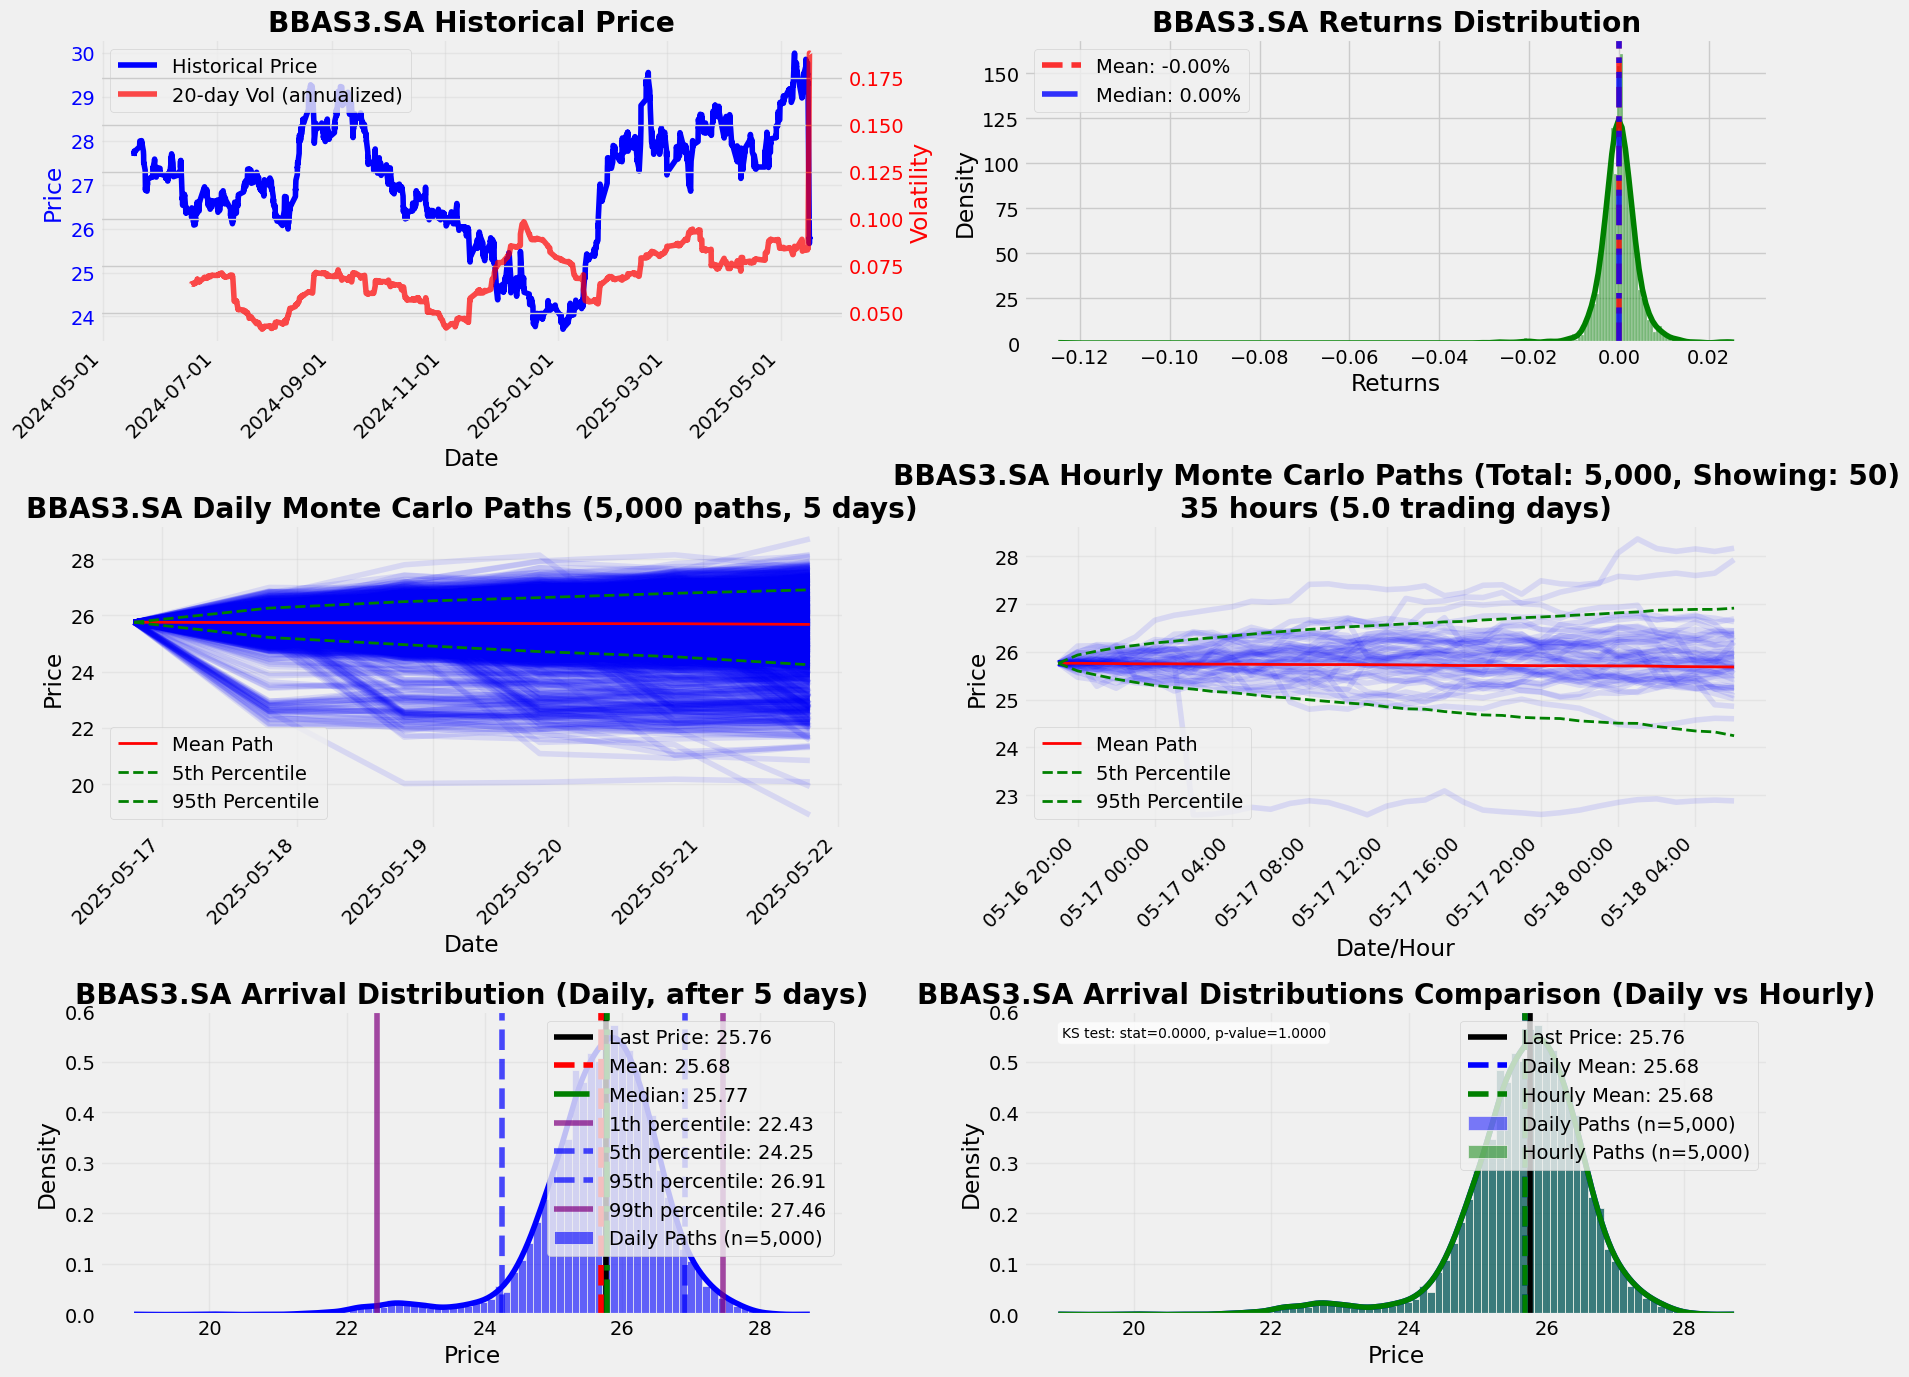

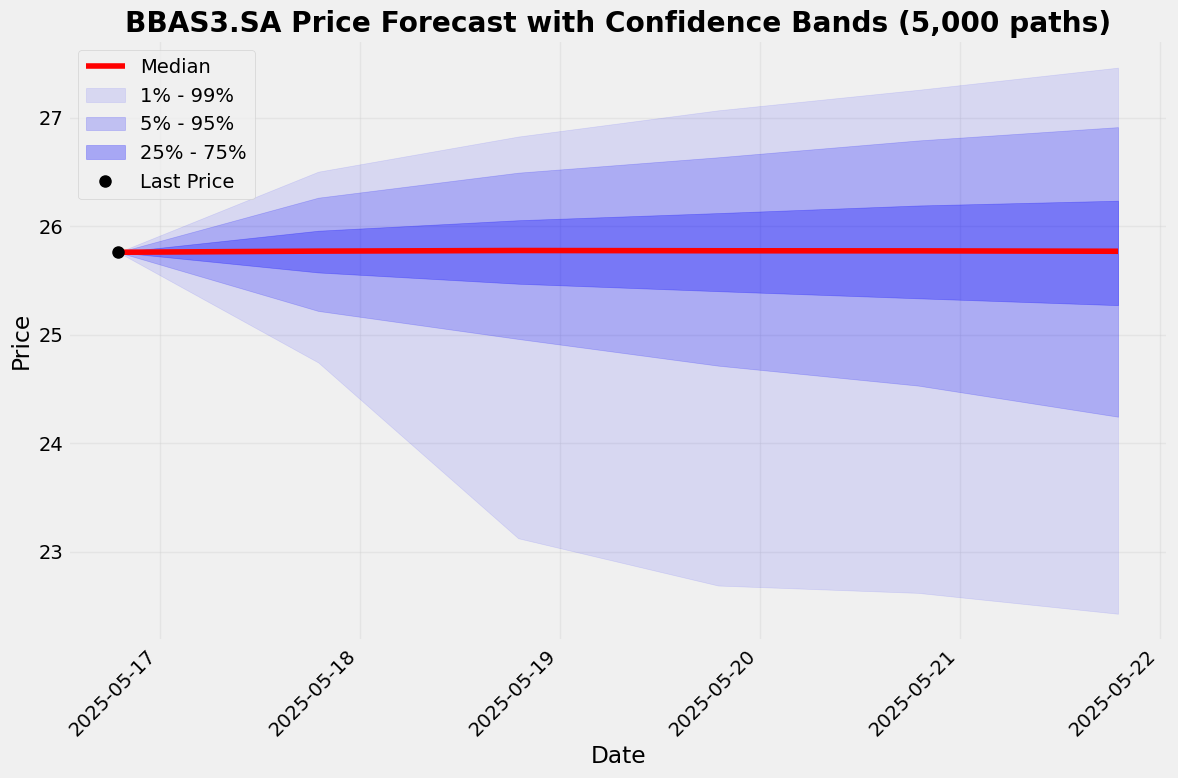


Key Statistics:
Last Price: $25.76
Mean Arrival Price: $25.68
Median Arrival Price: $25.77
Std Dev: $0.90
95% CI: [$24.25, $26.91]

Path Information Summary:
Daily Paths: 5,000
Hourly Paths: 5,000
Forecast Days: 5
Total Hours: 35
Hours per Day: 7

Fitting probability distribution to arrival values...
Best fitting distribution: t
Parameters: (3.7512087262683433, 25.76647290492894, 0.6246700872084365)
KS statistic: 0.0248
p-value: 0.0042
Best fitting distribution: t
Parameters: (3.7512087262683433, 25.76647290492894, 0.6246700872084365)
KS statistic: 0.0248
p-value: 0.0042


In [12]:
# Example usage
if __name__ == "__main__":
    # Set parameters
    ticker = "BBAS3.SA"  # Example ticker
    period_str = "1y"
    iterations = 5000
    forecast_days = 5
    hours_per_day = 7
    
    # Run the simulation
    print(f"Running simulation for {ticker} with {iterations} iterations...")
    results, asset_df, orig_data = run_bootstrap(ticker, period_str, iterations, forecast_days, hours_per_day)
    
    # Create plots
    print("Creating visualization plots...")
    figures = mc_plot(results, asset_df, orig_data)
    
    # Show the plots
    plt.show()
    
    # Print key statistics
    print("\nKey Statistics:")
    print(f"Last Price: ${results['last_price']:.2f}")
    print(f"Mean Arrival Price: ${results['monte_carlo']['stats']['mean']:.2f}")
    print(f"Median Arrival Price: ${results['monte_carlo']['stats']['median']:.2f}")
    print(f"Std Dev: ${results['monte_carlo']['stats']['std']:.2f}")
    print(f"95% CI: [${results['monte_carlo']['stats']['percentiles']['5%']:.2f}, ${results['monte_carlo']['stats']['percentiles']['95%']:.2f}]")
    
    # Print path summary
    if 'summary' in figures:
        summary = figures['summary']
        print(f"\nPath Information Summary:")
        print(f"Daily Paths: {summary['num_daily_paths']:,}")
        print(f"Hourly Paths: {summary['num_hourly_paths']:,}")
        print(f"Forecast Days: {summary['days']}")
        print(f"Total Hours: {summary['total_hours']}")
        print(f"Hours per Day: {summary['hours_per_day']}")
    
    # Find best fitting distribution
    print("\nFitting probability distribution to arrival values...")
    distribution_fit = get_best_fit_distribution(results)